# MNIST CNN Training with PyTorch
In this beginner-friendly notebook, we will explore how to train a Convolutional Neural Network (CNN) on the MNIST dataset using PyTorch. We'll start with the basics of loading and visualizing the dataset, then move on to defining and training our CNN. Along the way, we'll visualize the data and the training process to gain a better understanding of what's happening under the hood.

## Importing Libraries and Loading Data
To get started, we first import the necessary libraries that will help us in data handling, visualization, and neural network construction. We then load the MNIST dataset, a popular dataset of handwritten digits, and prepare it for training. Additionally, we define a function to display images from the dataset, which helps us visually verify the data we're working with. Let's see some examples of the MNIST images.

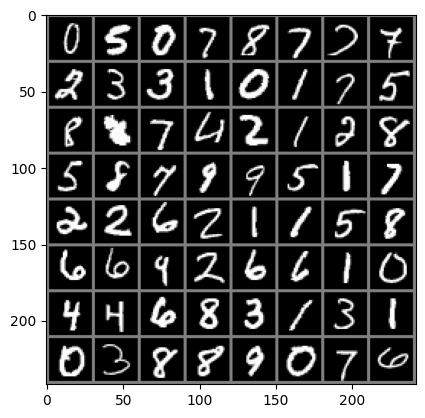

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

# Transformation for the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load MNIST training dataset
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Splitting the full training dataset into train and validation sets
train_proportion = 0.8 # 80% of the full training dataset for training, remaining 20% for validation
train_size = int(train_proportion * len(full_trainset))
validation_size = len(full_trainset) - train_size
trainset, validateset = random_split(full_trainset, [train_size, validation_size])

# Creating data loaders for the train and validation sets
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validateloader = DataLoader(validateset, batch_size=BATCH_SIZE, shuffle=True)

# Load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# Function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

## Defining the Training Function
Training a neural network involves several steps repeated over multiple iterations or epochs. To make our code clean and reusable, we define a `train_model` function. This function takes a neural network model, training and validation data loaders, a loss function, and an optimizer, and then performs the training process. It also implements early stopping to prevent overfitting.

In [24]:
def train_model(model, trainloader, validateloader, criterion, optimizer, num_epochs=10, patience=3, device='cuda'):
    best_loss = float('inf')
    epochs_no_improve = 0

    train_loss_list, validation_loss_list = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss_list.append(running_loss / len(trainloader))

        # Validation loss
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for data in validateloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

        validation_loss_list.append(validation_loss / len(validateloader))

        # Early stopping
        if validation_loss < best_loss:
            best_loss = validation_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

        print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}, Validation Loss: {validation_loss / len(validateloader)}')

    print('Finished Training')
    return train_loss_list, validation_loss_list

## Visualizing Training and Validation Loss
Tracking the training progress is crucial to understand how well our model is learning. This section introduces a function to plot the training and validation loss curves. These plots will help us visualize the model's learning behavior over epochs and adjust our training strategy if needed.


In [25]:
import matplotlib.pyplot as plt

def plot_train_val_loss(train_loss, val_loss):
    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.show()

## Defining the Evaluation Function
After training the model, we need to evaluate its performance on unseen data. In this section, we define an `evaluate_model` function that calculates various metrics such as accuracy, precision, recall, and F1 score on the test dataset. These metrics give us insights into the model's generalization capability.


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, testloader, device='cuda'):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    return accuracy, precision, recall, f1, conf_matrix

## Convolutional Neural Network (CNN) Architecture
Now, we define the architecture of our CNN. This section explains the structure of the CNN used for image classification on the MNIST dataset. We'll go through each layer of the network and understand its purpose and function.


In [27]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Training the CNN
With our CNN architecture defined, it's time to train the network. We set up the loss function and optimizer, which are key components of the training process. Then, we use our previously defined `train_model` function to train the CNN on the MNIST dataset. During training, we'll also visualize the loss curve to monitor the model's learning progress.


Using device: cpu
Epoch 1, Training Loss: 2.2515144567489624, Validation Loss: 1.9303892121670094
Epoch 2, Training Loss: 0.6659291739066442, Validation Loss: 0.3255656575189626
Epoch 3, Training Loss: 0.23487797978520394, Validation Loss: 0.18060532600638715
Finished Training


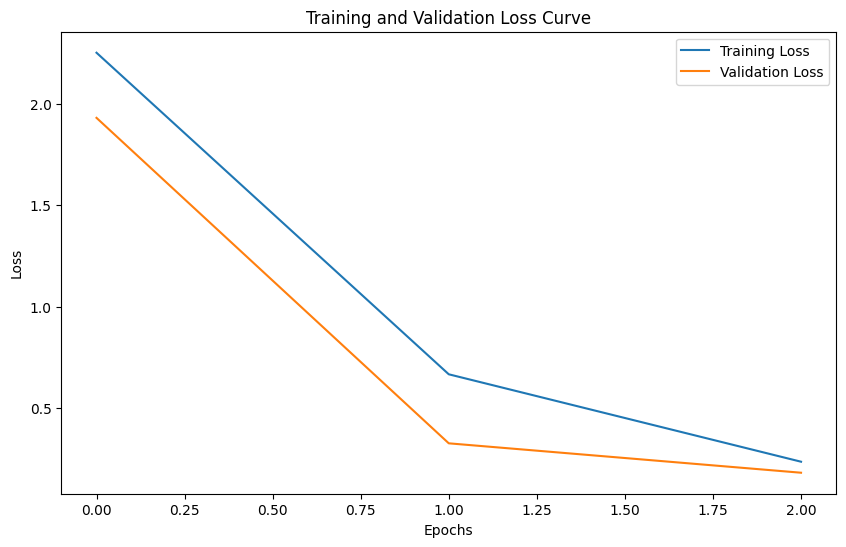

In [28]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the cnnwork
cnn = CNN().to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

# Initialize lists to track loss and validation loss
train_loss_list = []
validation_loss_list = []

train_loss, val_loss = train_model(cnn, trainloader, validateloader, criterion, optimizer, num_epochs=3, patience=3, device=device)
plot_train_val_loss(train_loss=train_loss, val_loss=val_loss)


### Evaluating the CNN
After training, the next step is to evaluate the model's performance on the test dataset. In this final section, we use the `evaluate_model` function to test the CNN and calculate performance metrics.

In [29]:
# Put the network on the device
cnn.to(device)

accuracy, precision, recall, f1, conf_matrix = evaluate_model(cnn, testloader, device=device)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.9506
Precision: 0.9511
Recall: 0.9506
F1 Score: 0.9506
Confusion Matrix:
 [[ 974    0    2    0    0    0    2    1    1    0]
 [   0 1096    3    4    1    1   10    2   17    1]
 [  15    0  973    4    6    0    1   12   17    4]
 [   2    0   11  967    1   10    0    7    8    4]
 [   2    0    2    0  949    0    7    1    3   18]
 [  10    1    1   22    0  830    4    2   14    8]
 [  17    2    4    0   13    3  916    0    3    0]
 [   2    1   23    6    3    0    0  957    8   28]
 [  12    0    7   10    8    3    1   14  901   18]
 [  12    2    0    7   18    6    0   13    8  943]]
